In [1]:
from biocrnpyler.mechanism import *
from biocrnpyler.chemical_reaction_network import Species, Reaction, ComplexSpecies, Multimer
import numpy as np
import pylab as plt 

class transcription_temperature(Mechanism):
    # G + RNAP -->(k1) G:RNAP(closed) -->(k2) G:RNAP(open)----->(k3)   G+RNAP+mRNA
    #Set the name and mechanism_type
    def __init__(self, name="transcription_temperature", rnap="RNAP", mechanism_type="transcription", **keywords):
        if isinstance(rnap, Species):
            self.rnap = rnap
        elif isinstance(rnap, str):
            self.rnap = Species(name=rnap, material_type="protein")
        elif isinstance(rnap, Component) and rnap.get_species() != None:
            self.rnap = rnap.get_species()
        else:
            raise ValueError(
                "'rnap' parameter must be a string or a Component with defined "
                "get_species(), or a chemical_reaction_network.Species object")
        Mechanism.__init__(self, name=name, mechanism_type=mechanism_type, **keywords)
     
    #Overwrite update_species
    def update_species(self, dna, return_rnap = True, transcript = None, **keywords):
        
        species = [dna]
        if return_rnap:
            species += [self.rnap]
        
        closedcomplex = ComplexSpecies([dna,self.rnap])
        opencomplex = Species(name="opencomplex")
        species+= [opencomplex, closedcomplex]
        
        if transcript is None: #Species names can be automatically created
            transcript = Species(dna.name, material_type = "rna")
        species += [transcript]

        return species #it is best to return all species that will be involved in the reactions

    #Overwrite update_reactions
    #This always requires the inputs component and part_id to find the relevant parameters
    def update_reactions(self, dna, component, part_id, transcript = None, **keywords):

        if transcript is None: #Species names should be automatically created the same here as above
            transcript = Species(dna.name, material_type = "rna")
            
        closedcomplex = ComplexSpecies([dna,self.rnap])
        opencomplex = Species(name=dna.name + "_opencomplex")

        
        
        k1 = component.get_parameter("k1", part_id = part_id, mechanism = self)
        k2 = component.get_parameter("k2", part_id = part_id, mechanism = self)
        k3 = component.get_parameter("k3", part_id = part_id, mechanism = self)    
        Temperature= component.get_parameter("Temperature", part_id=part_id, mechanism = self)
        A = component.get_parameter("A", part_id = part_id, mechanism = self)
        B = component.get_parameter("B", part_id = part_id, mechanism = self)
        C = component.get_parameter("C", part_id = part_id, mechanism = self)
        
        
        rate_string= "(" + str(dna)+ "*"+ "(" + "1" + "/" + "(" + str(A) + "*" + str(Temperature) + "^" + "2" + "+" + str(B) + "*" + str(Temperature) + "+" + str(C) + ")"+ ")" + ")"
               
        reaction_1 = Reaction(inputs = [dna, self.rnap], outputs = [closedcomplex], k = k1, propensity_type = "general",
                              propensity_params= { "rate": rate_string})
        reaction_2 = Reaction(inputs = [closedcomplex], outputs = [opencomplex], k = k2)
        reaction_3 = Reaction(inputs = [opencomplex], outputs = [dna, self.rnap, transcript], k = k3)                           

        #In this case, we just return one reaction
        return [reaction_1, reaction_2, reaction_3]

In [2]:
%matplotlib inline
from biocrnpyler import *

lac_ara_1= Promoter("lac_ara_1")

G = DNAassembly("X", promoter = "lac_ara_1")

mech_tx= transcription_temperature()
default_mechanisms={"transcription":mech_tx}
default_parameters ={"k1":0.01, "k2":0.66, "k3":100000, "Temperature":37, "A": 0.0576 , "B": -4.68 , "C": 120 }
M = Mixture("TxTlMixture", components = [G], parameters = default_parameters, mechanisms= default_mechanisms)

CRN = M.compile_crn()

print("Pretty_print representation of the CRN:\n",
      CRN.pretty_print(show_rates = True, show_attributes = True, show_materials = True))

Pretty_print representation of the CRN:
 Species (5) = {0. rna[X], 1. opencomplex, 2. complex[dna[X]:protein[RNAP]], 3. dna[X], 4. protein[RNAP]}
Reactions (3) = [
0. dna[X] + protein[RNAP] --> complex[dna[X]:protein[RNAP]]        
        general: k(x)=0.01*(dna_X*(1/(0.0576*37^2+-4.68*37+120)))
1. complex[dna[X]:protein[RNAP]] --> X_opencomplex        
        massaction: k_f(complex[dna[X]:protein[RNAP]])=0.66*complex[dna[X]:protein[RNAP]]
2. X_opencomplex --> dna[X] + protein[RNAP] + rna[X]        
        massaction: k_f(X_opencomplex)=100000*X_opencomplex
]


/home/nazmus/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/home/nazmus/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/nazmus/anaconda3/lib/python3.7/site-packages/biocrnpyler-0.2.1-py3.7.egg/biocrnpyler/chemical_reaction_network.py:1089: UserWarning: The following species are uninitialized and their value has been defaulted to 0: X_opencomplex, Y_opencomplex, 
/home/nazmus/anaconda3/lib/python3.7/site-packages/biocrnpyler-0.2.1-py3.7.egg/biocrnpyler/chemical_reaction_network.py:1089: UserWarning: The following species are uninitialized and their value has been defaulted to 0: X_opencomplex, Y_opencomplex, 


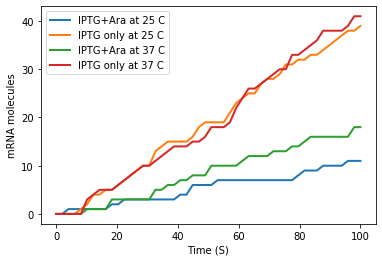

In [3]:

temp_vals={25, 37}
timepoints = np.linspace(0, 100, 50)
mech_tx= transcription_temperature()
default_mechanism={"transcription":mech_tx}

for val in temp_vals: 
    
    P1= Promoter("lac_ara_1")
    P2= Promoter("lac_ara_1")
    G1 = DNAassembly("X", promoter = "P1", 
                     parameters={"k1":0.01, "k2":0.66, "k3":100000, "Temperature":val, "A": 0.0576 , "B": -4.68 , "C": 120 }
                    , mechanisms= default_mechanism)
    G2 = DNAassembly("Y", promoter = "P2",
                     parameters={"k1":0.001, "k2":0.16, "k3":100000, "Temperature":val, "A": 0.0095 , "B": -0.77 , "C": 20 }
                    , mechanisms= default_mechanism)
    
    M1 = Mixture("TxTlMixture", components = [G1, G2])
    
    CRN1 = M1.compile_crn()
    R = CRN1.simulate_with_bioscrape(timepoints = timepoints, 
                                    initial_condition_dict = {"dna_X":5, "dna_Y":5}, stochastic= True )
    plt.plot(timepoints, R["rna_X"], label= "IPTG+Ara at "+ str(val) + " C", lw = 2)
    plt.plot(timepoints, R["rna_Y"], label= "IPTG only at "+ str(val)+ " C", lw = 2)
    
 #   plt.plot(timepoints, R["complex_dna_X_protein_RNAP"], label= "opencomplex "+ str(val), lw = 2)


plt.xlabel("Time (S)")
plt.ylabel("mRNA molecules");
plt.legend()
plt.show()